## Import Packages

In [2]:
import numpy as np
import pandas as pd
from pytrends.request import TrendReq
import json
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

### Extract confirmed case numbers for target countries

In [3]:
covid_all = pd.read_csv("time_series_covid19_confirmed_global.csv")

In [4]:
def extract_target_country_case(filename, country_list):
    covid_all = pd.read_csv(filename)
    covid_target = covid_all[covid_all['Country/Region'].isin(country_list)]
    covid_target = covid_target.drop(columns=['Province/State','Lat','Long'])
    # adding up the confirmed case numbers for countires with multiple rows
    for country in country_list:
        covid_multiple_rows = covid_target[covid_target['Country/Region']==country]
        if covid_multiple_rows.shape[0] > 1:
            covid_target = covid_target.drop(covid_multiple_rows.index)
            covid_single_row = covid_multiple_rows.groupby('Country/Region').sum().reset_index()
            covid_target = covid_target.append(covid_single_row).reset_index(drop=True)
        else:
            continue
    return(covid_target)

In [5]:
filename = "time_series_covid19_confirmed_global.csv"
country_dict = {'Taiwan*':'TW', 'Korea, South':'KR', 'Italy':'IT', 'Spain':'ES', 'Czechia':'CZ', 
                     'US':'US', 'Peru':'PE', 'Iran':'IR', 'Australia':'AU', 'South Africa':'ZA'}
country_list = list(country_dict.keys())
confirmed_case_target = extract_target_country_case(filename, country_list)

* Problem: need to manually search for the country names used in the dataset and modify our country_name list accordingly --> use Regex to find similar country names?

### Transpose confirmed_case_target dataframe

In [6]:
df_country = pd.DataFrame(country_dict.items(), columns=['Name','Code'])
confirmed_case_target = pd.merge(confirmed_case_target, df_country, how='left', left_on='Country/Region', right_on='Name')
confirmed_case_tr = confirmed_case_target.transpose()

# set country code as the column names of the transposed dataframe
confirmed_case_tr.columns = confirmed_case_tr.loc['Code']
confirmed_case_tr = confirmed_case_tr.drop(['Country/Region','Name','Code'])

# set date as the index of the transposed dataframe
confirmed_case_tr.index = pd.to_datetime(confirmed_case_tr.index)

In [108]:
# (old)only for extracting keywords together
def extract_google_trends(timeframe, keywords_dict):
    timeframe = timeframe[0]+" "+timeframe[1]
    pytrend = TrendReq(hl='en-US', tz=360)
    result_dict = {}
    for key in list(keywords_dict.keys())[:-1]:
        pytrend.build_payload(kw_list=keywords_dict[key], cat=0, timeframe=timeframe, geo=key)
        result_local = pytrend.interest_over_time().drop(columns=['isPartial'])
        if key == 'US':
            result = result_local
        else:
            result_local.columns = [keyword+"(local)" for keyword in keywords_dict['common']]
            pytrend.build_payload(kw_list=keywords_dict['common'], cat=0, timeframe=timeframe, geo=key)
            result_common = pytrend.interest_over_time().drop(columns=['isPartial'])
            result = pd.concat([result_local, result_common], axis=1)
        result['date'] = result.index.strftime("%Y/%m/%d")
        result_dict[key] = result
    return(result_dict)

In [7]:
# extract Google Trends of single(multiple) keyword(s) for each target country
def extract_google_trends(timeframe, keywords_dict, single_search=True):
    timeframe = timeframe[0]+" "+timeframe[1]
    pytrend = TrendReq(hl='en-US', tz=360)
    result_dict = {}
    for key in list(keywords_dict.keys())[:-1]:
        # extract Google Trends of single keyword for each target country
        if single_search:
            result = pd.DataFrame()
            for word in keywords_dict[key]:
                pytrend.build_payload(kw_list=[word], cat=0, timeframe=timeframe, geo=key)
                if pytrend.interest_over_time().empty:
                        result = pd.concat([result, pd.DataFrame(0, index=result.index, columns=[word])], axis=1)
                result = pd.concat([result, pytrend.interest_over_time()], axis=1)
            # extract Google Trends of English keywords for each target country
            if key != 'US':
                result = result.drop(columns=['isPartial'])
                result.columns = [keyword+"(local)" for keyword in keywords_dict['common']]
                for word in keywords_dict['common']:
                    pytrend.build_payload(kw_list=[word], cat=0, timeframe=timeframe, geo=key)
                    result = pd.concat([result, pytrend.interest_over_time()], axis=1)
            result = result.drop(columns=['isPartial'])
            
        # extract Google Trends of multiple keywords for each target country
        else:
            pytrend.build_payload(kw_list=keywords_dict[key], cat=0, timeframe=timeframe, geo=key)
            result_local = pytrend.interest_over_time().drop(columns=['isPartial'])
            if key == 'US':
                result = result_local
            # extract Google Trends of English keywords for each target country
            else:
                result_local.columns = [keyword+"(local)" for keyword in keywords_dict['common']]
                pytrend.build_payload(kw_list=keywords_dict['common'], cat=0, timeframe=timeframe, geo=key)
                result_common = pytrend.interest_over_time().drop(columns=['isPartial'])
                result = pd.concat([result_local, result_common], axis=1)        
        result_dict[key] = result
    return(result_dict)

In [8]:
timeframe = ('2020-01-01', confirmed_case_tr.index.strftime('%Y-%m-%d')[-1])
keywords_dict = {'TW':['武漢', '冠狀病毒', '武漢肺炎', '肺炎', '新冠肺炎'],
                 'KR':['우한', '코로나바이러스', '우한 폐렴', '폐렴', '신종 코로나바이러스'],
                 'US':['Wuhan', 'coronavirus', 'Wuhan coronavirus', 'pneumonia', 'covid'],
                 'common':['Wuhan', 'coronavirus', 'Wuhan coronavirus', 'pneumonia', 'covid']}

single_google_trends_dict = extract_google_trends(timeframe, keywords_dict)
multi_google_trends_dict = extract_google_trends(timeframe, keywords_dict, single_search=False)

### Merge confirmed case dataframe to Google Trends query results
* Reference:
https://thispointer.com/pandas-how-to-merge-dataframes-by-index-using-dataframe-merge-part-3/

In [9]:
for dictionary in [single_google_trends_dict, multi_google_trends_dict]:
    for key in dictionary:
        df_merged = pd.merge(dictionary[key], confirmed_case_tr[key], how='left', left_index=True, right_index=True)
        df_merged[key] = df_merged[key].fillna(0)
        dictionary[key] = df_merged.rename(columns={key:"Confirmed Case"})

### Plot Google Trends query results (keywords are extrated together) vs. confirmed case number over time
* Reference:
#### (1) https://seaborn.pydata.org/tutorial/color_palettes.html
#### (2) https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/

In [10]:
def plot_GT_case_trends(t, popularity, country, local=True):
    confirmed_case = popularity['Confirmed Case']
    if local: # when keywords are searched in local language
        popularity = popularity.iloc[:,:5]
        title = "Popularity of Google Search Queries(in local language) & Number of Confirmed Cases Over Time_"+country
    else: # when keywords are searched in English
        popularity = popularity.iloc[:,5:-1]
        title = "Popularity of Google Search Queries(in English) & Number of Confirmed Cases Over Time_"+country
   
    label = list(popularity.columns)
    color = sns.color_palette("husl", len(label))  
    
    # plot Google Trends query trend 
    fig, ax1 = plt.subplots(figsize=(25, 10))
    for i in range(len(label)):    
        ax1.plot(t, popularity.iloc[:,i], color=color[i], label=label[i], linewidth=3)
        
    ax2 = ax1.twinx()
    ax2.plot(t, confirmed_case, color='red', label='# of Confirmed Cases', linewidth=5)

    date_form = mdates.DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.set_ylabel('Popularity of Query', fontsize=20)
    ax2.set_ylabel('Number of Confirmed Cases', fontsize=20, color='red')
    ax1.tick_params(axis='x', labelsize=15, labelrotation=45)
    ax1.tick_params(axis='y', labelsize=15)
    ax2.tick_params(axis='y', labelcolor='red', labelsize=15)
    ax1.grid(linewidth=0.5, color='gray')
    fig.legend(fontsize=15, loc=(0.07,0.7))
    plt.title(title, fontsize=25)
    plt.show()

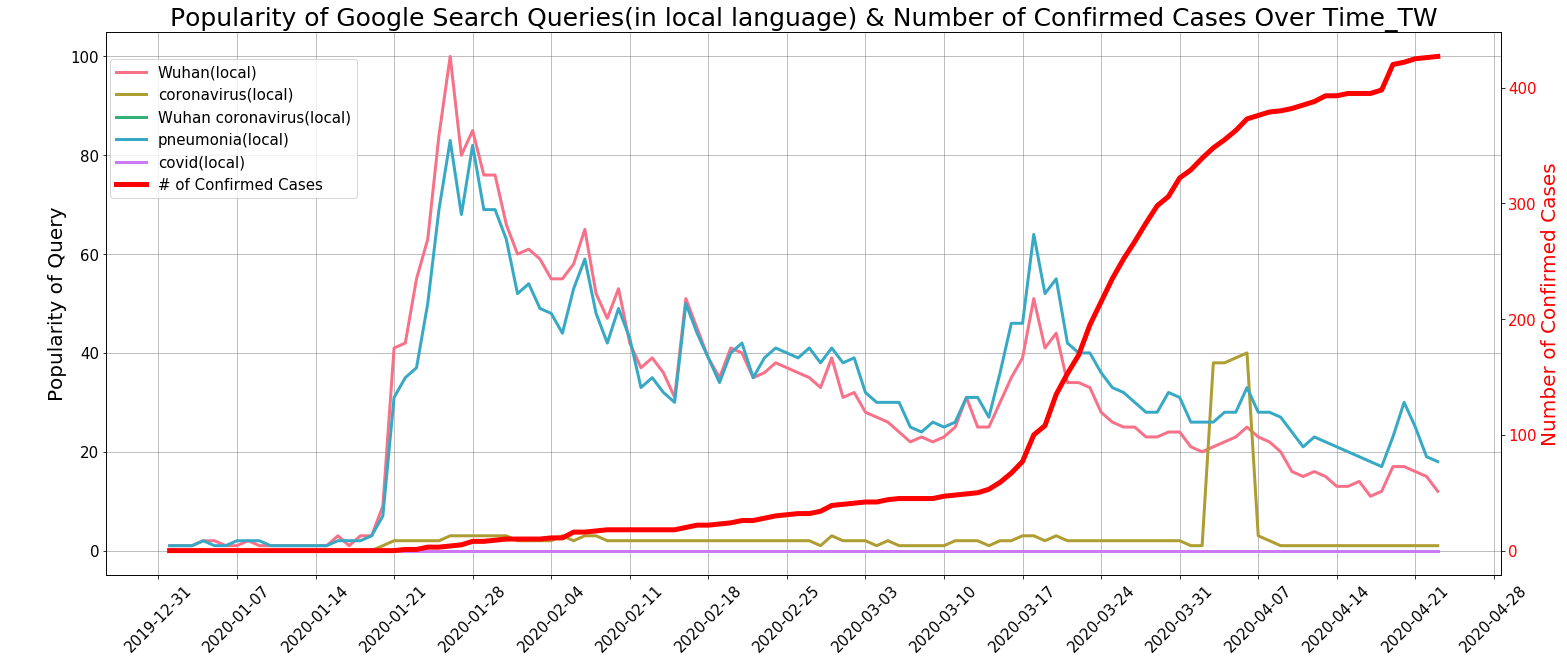

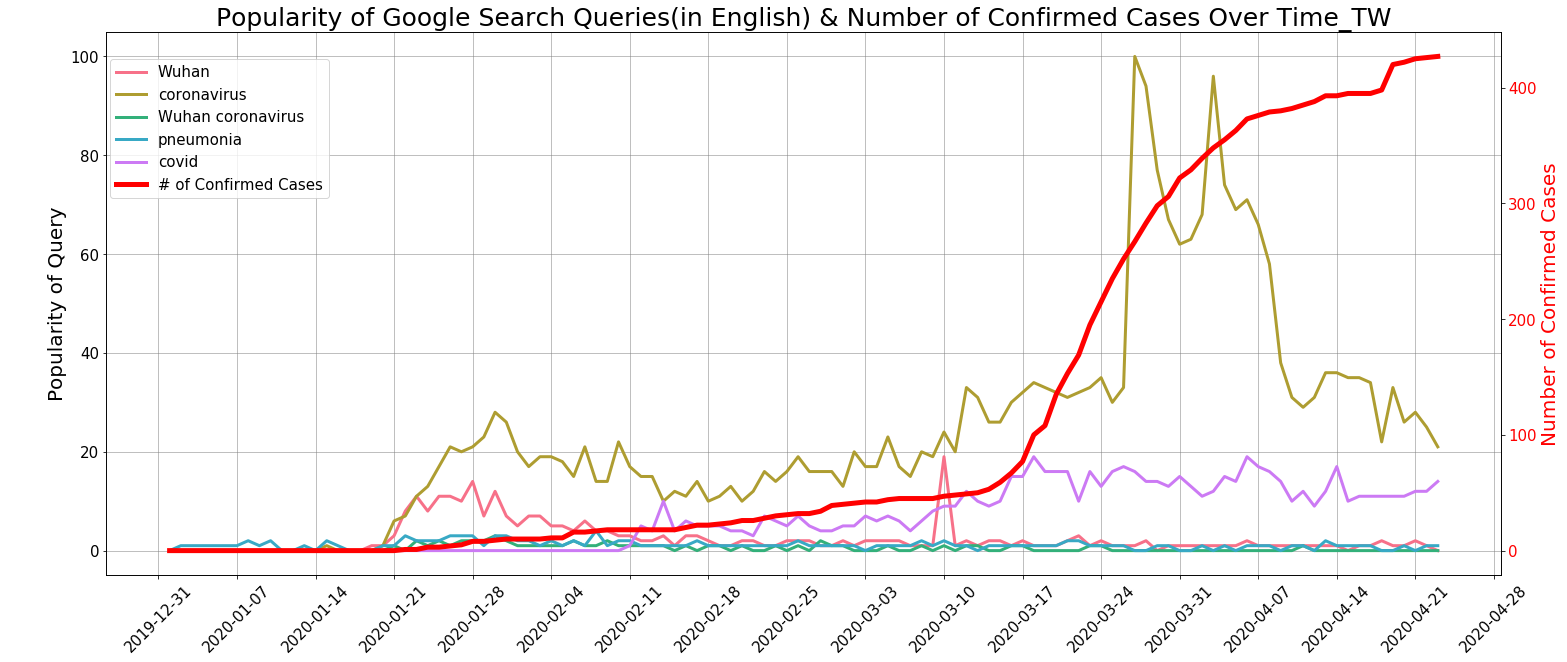

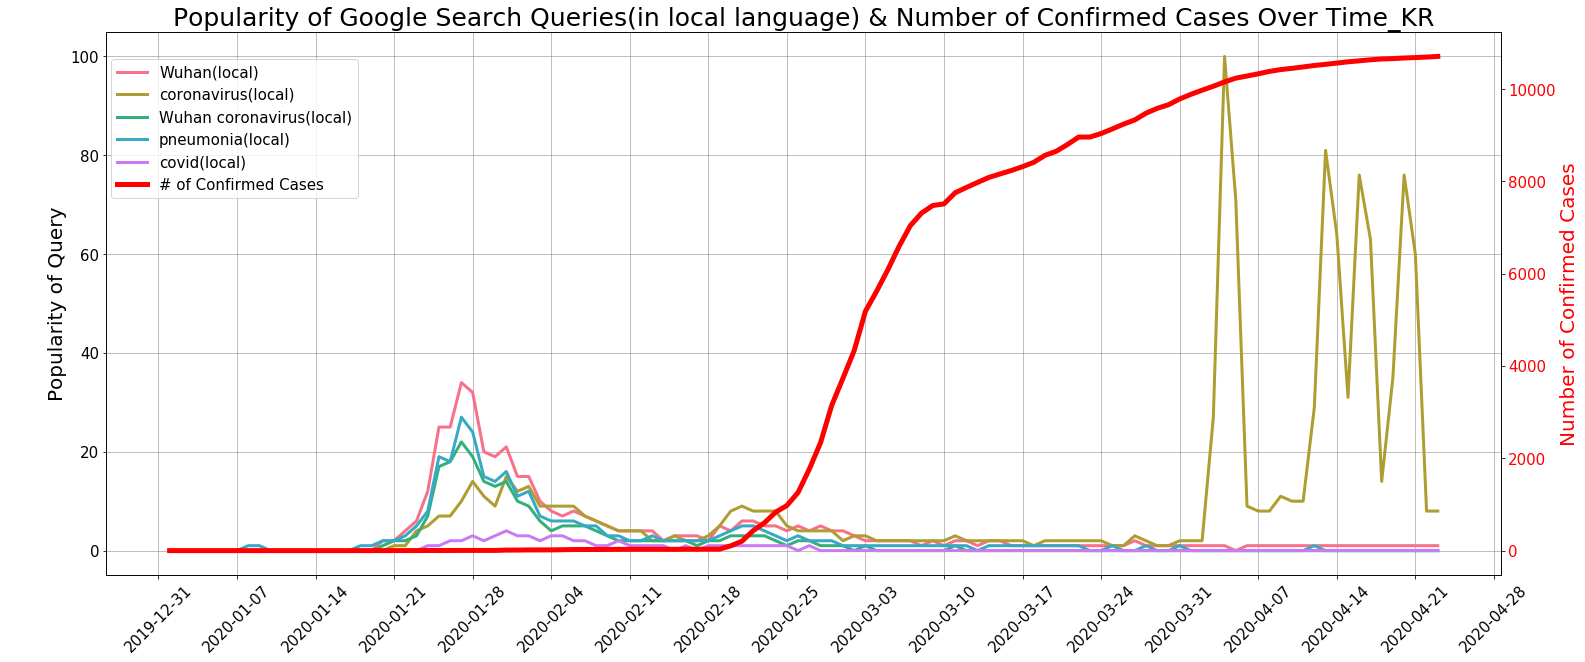

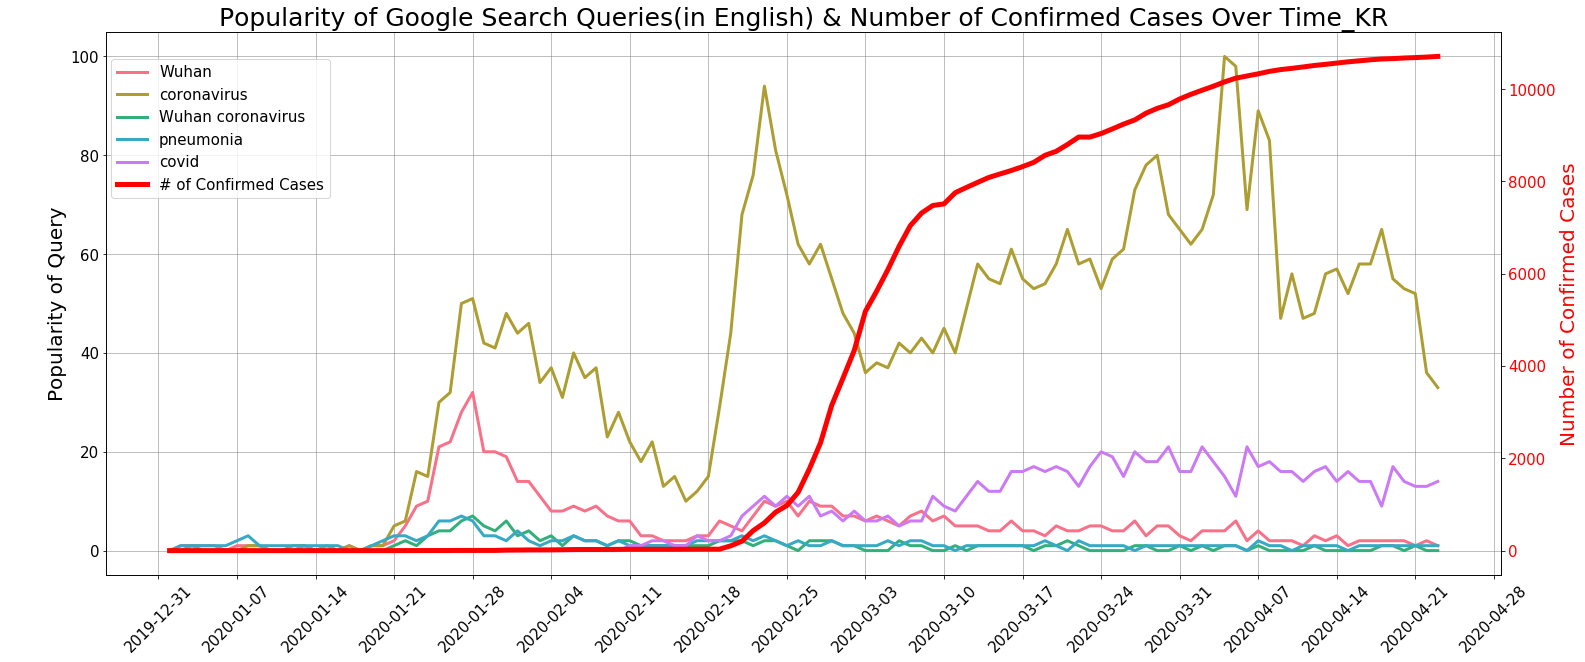

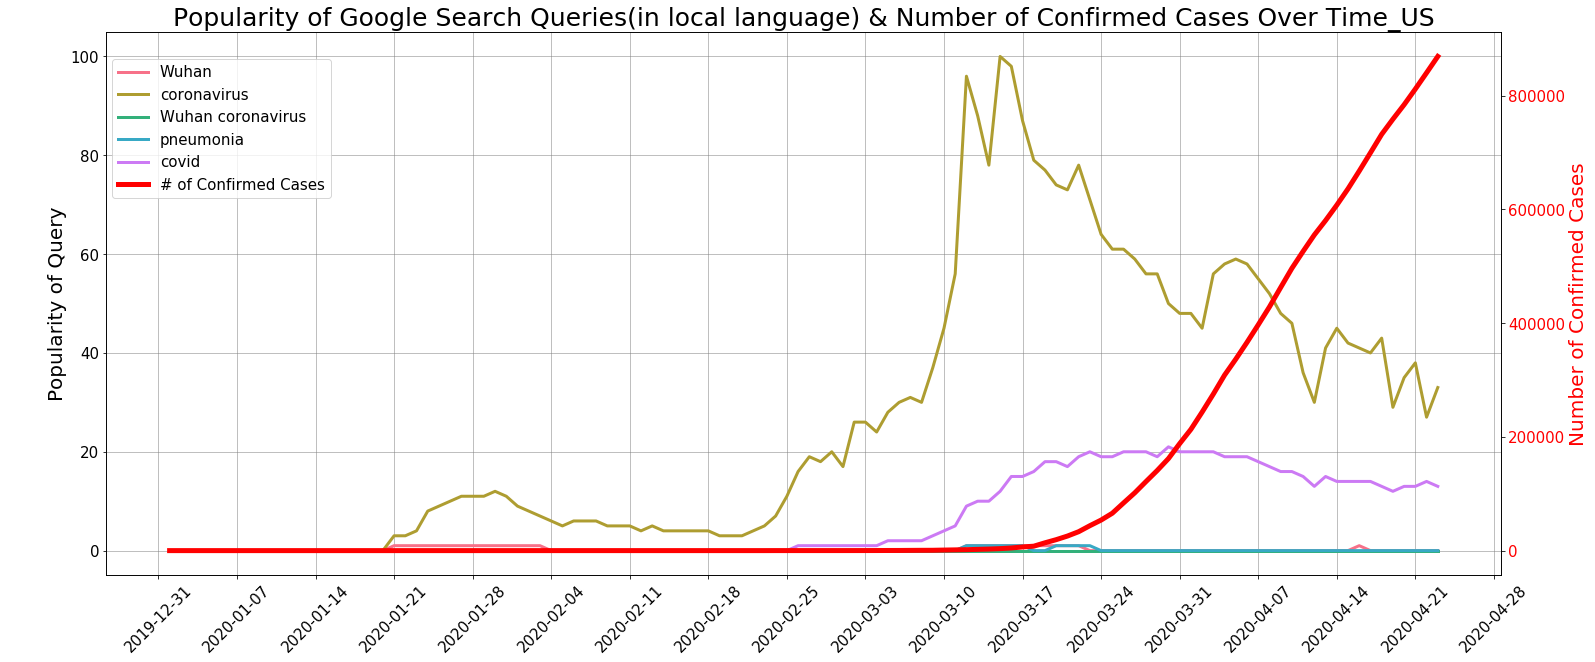

In [12]:
for key in multi_google_trends_dict:
    popularity = multi_google_trends_dict[key]
    t = popularity.index.values
    plot_GT_case_trends(t, popularity, key)
    if key != 'US':
        plot_GT_case_trends(t, popularity, key, local=False)

### Actual searching results on Google Trends website:

<img src="TW_together.png">

<img src="KR_together.png">

<img src="US_together.png">

### Plot Google Trends query results (keywords are extrated individually) vs. confirmed case number over time

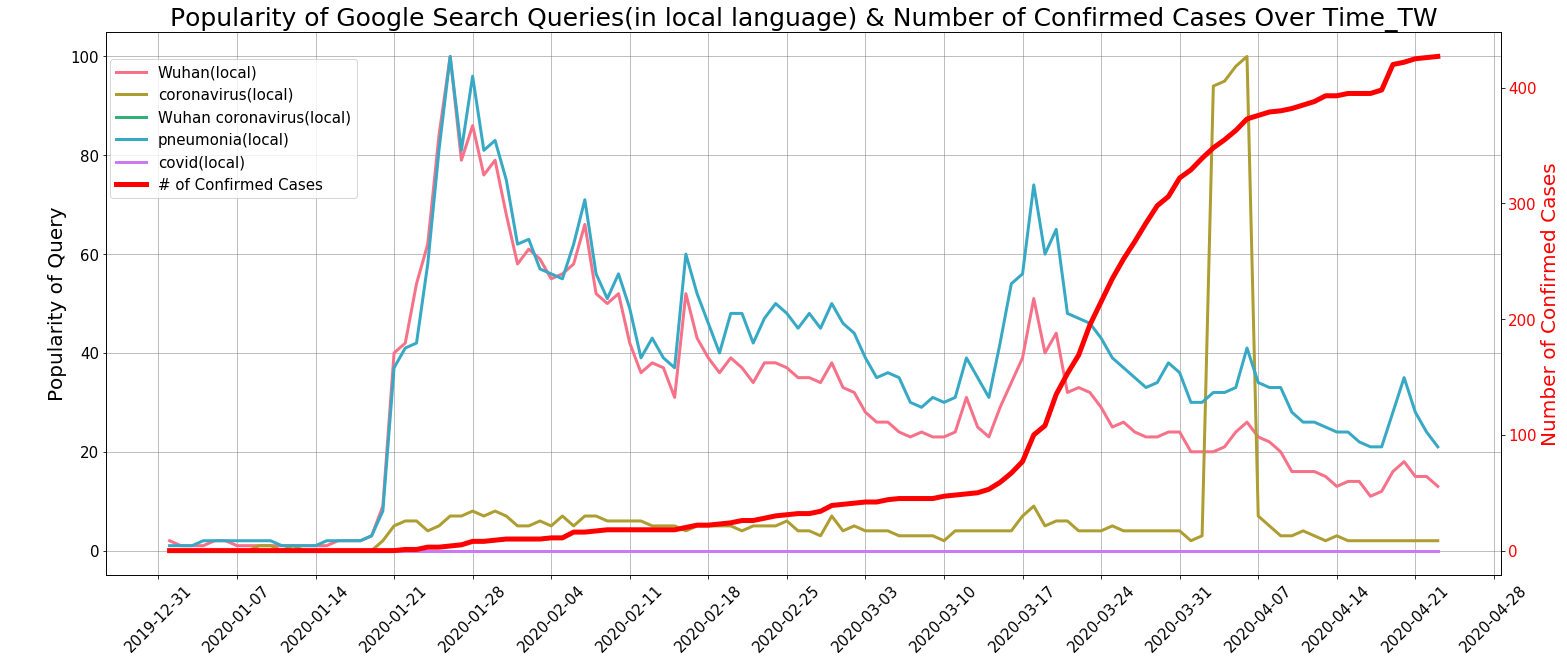

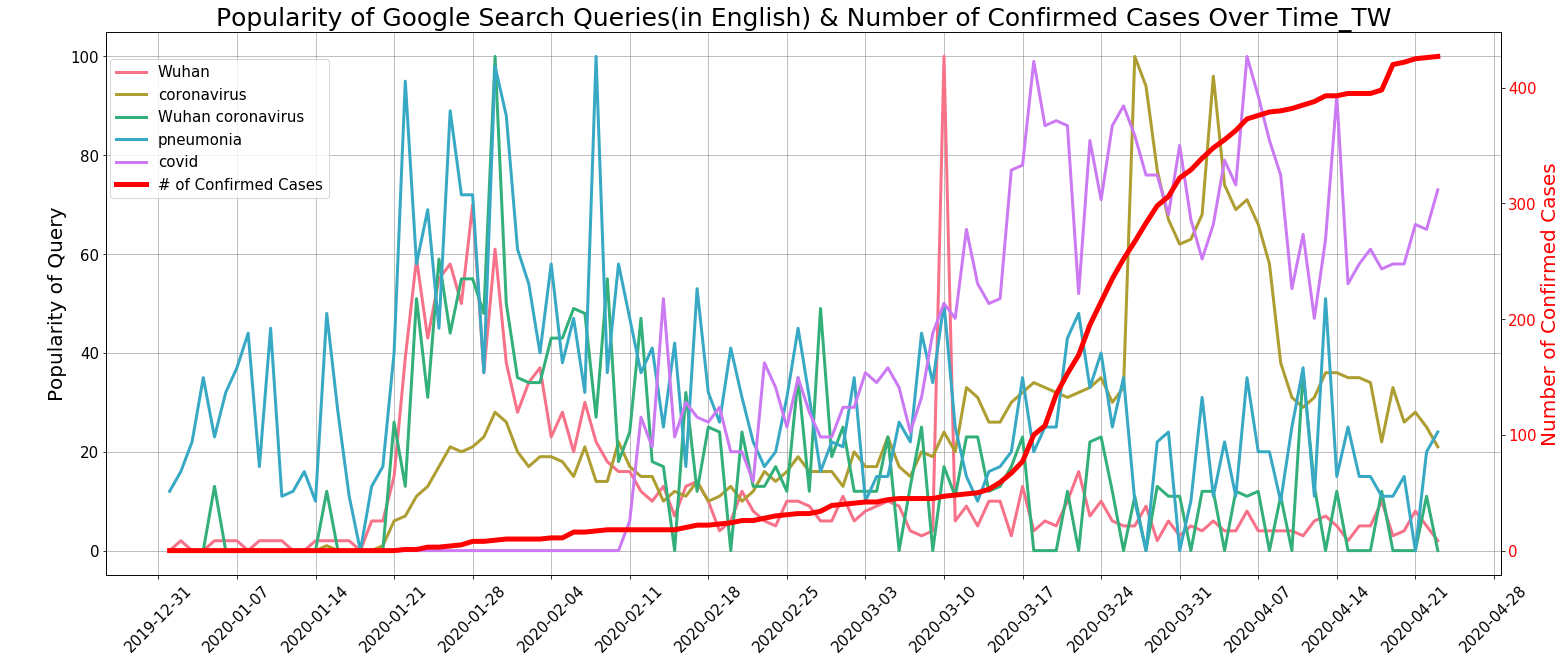

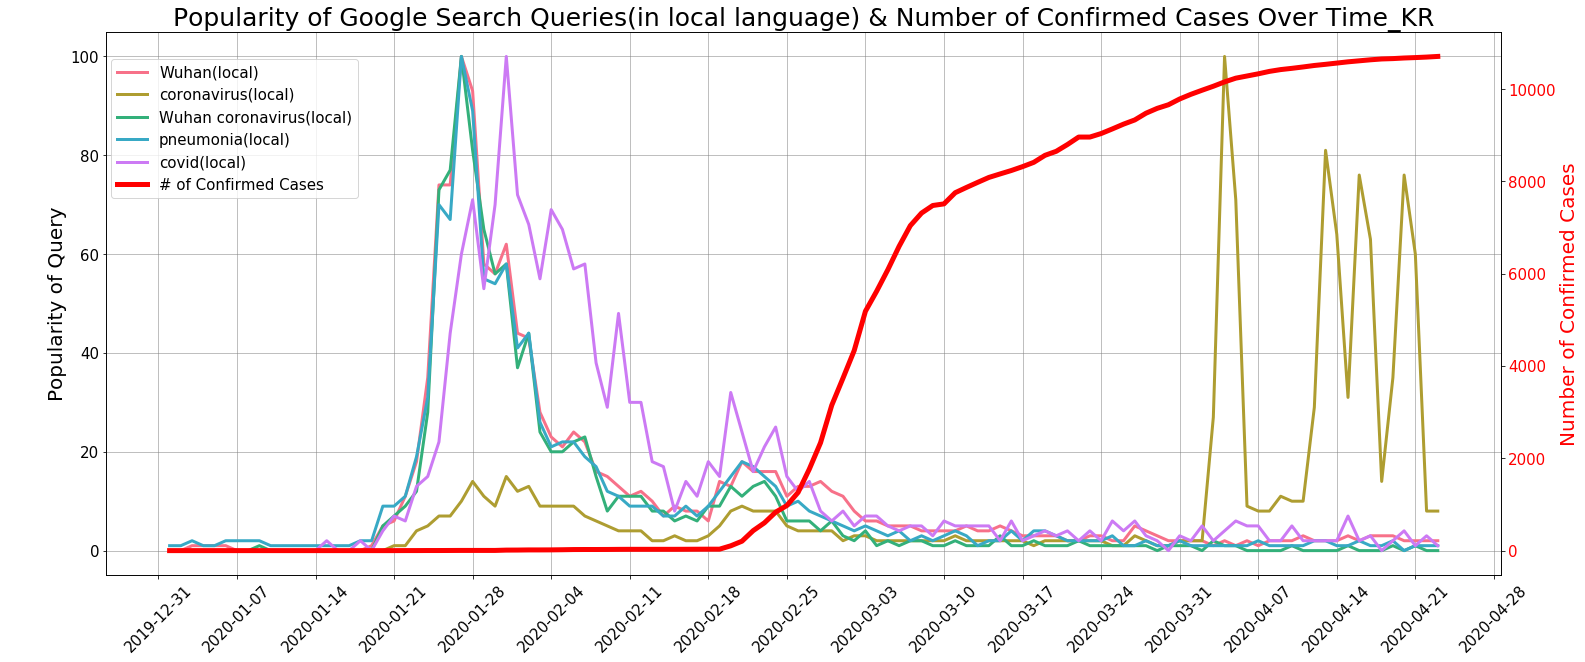

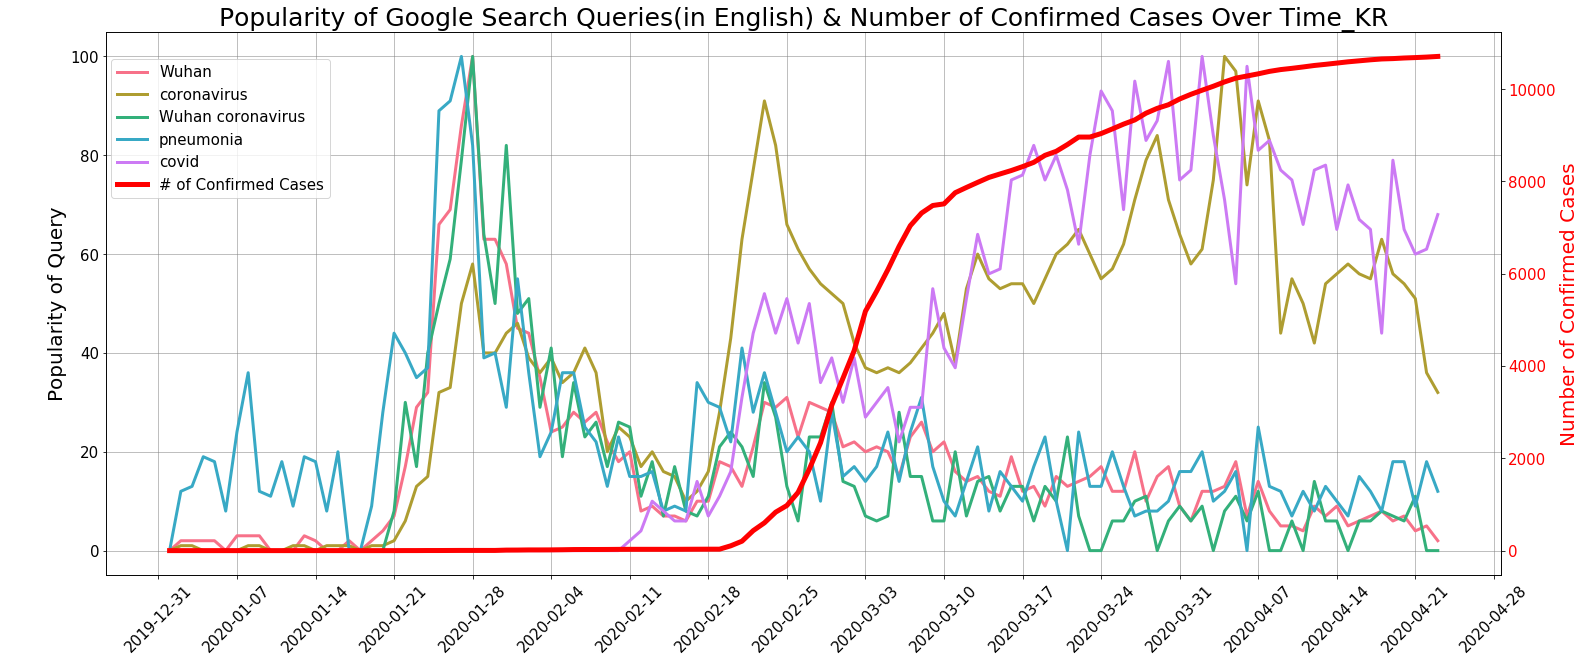

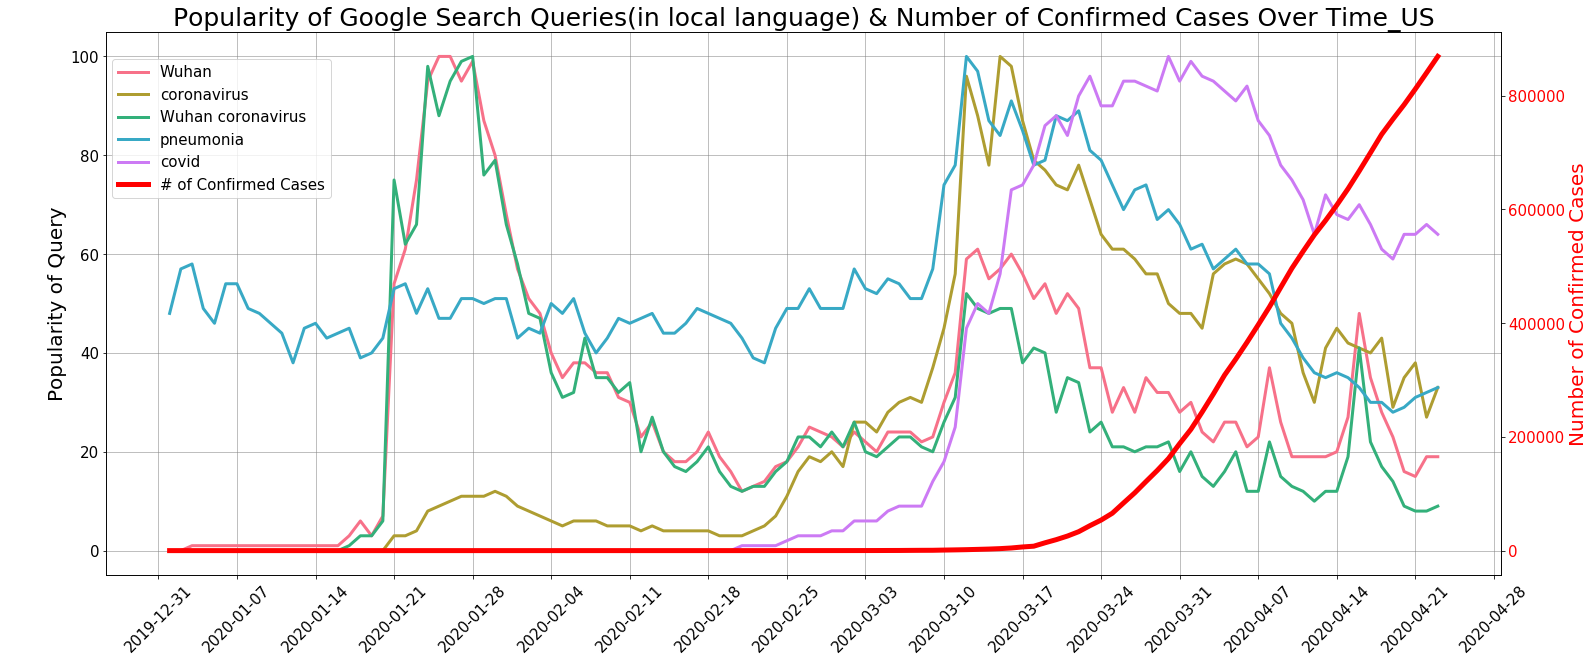

In [13]:
for key in single_google_trends_dict:
    popularity = single_google_trends_dict[key]
    t = popularity.index.values
    plot_GT_case_trends(t, popularity, key)
    if key != 'US':
        plot_GT_case_trends(t, popularity, key, local=False)

### Findings:

### 1. 台灣的'武漢肺炎'、'新冠肺炎'因搜尋資料不足皆為0

<img src="TW_Wuhan coronavirus(local).png">

<img src="TW_covid(local).png">

### 2. "確診“, ”症狀“, ”疫情“等相關搜尋字串是否考慮列入keyword?

In [15]:
pytrend = TrendReq(hl='en-US', tz=360)
pytrend.build_payload(kw_list=['武漢'], cat=0, timeframe='2020-01-01 2020-04-19', geo='TW', gprop='')
wuhan_related = pytrend.related_queries()
wuhan_related['武漢']['top'] 

,query,value
0,肺炎 武漢,100
1,武漢 台灣,15
2,台灣 武漢 肺炎,14
3,武漢 疫情,13
4,武漢 肺炎 疫情,10
5,武漢 症狀,9
6,武漢 肺炎 症狀,8
7,武漢 確診,6
8,武漢 肺炎 最新,6
9,武漢 肺炎 確診,5
